In [1]:
import pandas as pd
import json
import openai
import requests
from tqdm import tqdm

In [2]:
with open('openai_key.txt', encoding='utf-8') as f:
    openai_key = f.readlines()[0]
openai.api_key = openai_key


def file_upload(filename, purpose='fine-tune'):
    resp = openai.File.create(purpose=purpose, file=open(filename))
    print(resp)
    return resp


def finetune_model(fileid, suffix, model='davinci', valid=None, n_classes=None, clf=False):
    header = {'Content-Type': 'application/json', 'Authorization': 'Bearer %s' % openai_key}
    payload = {'training_file': fileid, 'model': model, 'suffix': suffix}
    if valid:
        payload['validation_file'] = valid
        if clf:
            if not n_classes:
                raise AttributeError('n_classes must be specified')

            payload['compute_classification_metrics'] = clf
            payload['classification_n_classes'] = n_classes


    resp = requests.request(method='POST', url='https://api.openai.com/v1/fine-tunes', json=payload, headers=header, timeout=45)
    print(resp.json())


def load_model(model_name):
    model = openai.Model.retrieve(model_name)
    return model

In [3]:
al_test = pd.read_json('datasets/alhindi.jsonl', lines=True)
zh_test = pd.read_json('datasets/zhijing.jsonl', lines=True)

In [4]:
upload = True
if upload:
    train_resp = file_upload('datasets/train.jsonl')
    valid_resp = file_upload('datasets/eval.jsonl')

{
  "bytes": 191260,
  "created_at": 1686183481,
  "filename": "file",
  "id": "file-wRChzYpiDP2h6f3qjMi2T60i",
  "object": "file",
  "purpose": "fine-tune",
  "status": "uploaded",
  "status_details": null
}
{
  "bytes": 68073,
  "created_at": 1686183483,
  "filename": "file",
  "id": "file-Rwroc0ciUhw6wvNDrVmumrgb",
  "object": "file",
  "purpose": "fine-tune",
  "status": "uploaded",
  "status_details": null
}


In [5]:
finetune = False
if finetune:
    finetune_model(train_resp['id'], suffix='identification_valid', model='davinci', valid=valid_resp['id'], n_classes=12, clf=True)

In [12]:
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer %s' % openai_key}
payload = {'training_file': train_resp['id'], 
           'model': 'davinci', 
           'suffix': 'identification_valid',
           'validation_file':valid_resp['id'],
           'compute_classification_metrics':True,
           'classification_n_classes':12}
resp = requests.request(method='POST', url='https://api.openai.com/v1/fine-tunes', json=payload, headers=header, timeout=45)

In [61]:
resp.json()

{'object': 'fine-tune',
 'id': 'ft-qhULSsL9hUfDeMULAwWCvUIm',
 'hyperparams': {'n_epochs': 4,
  'batch_size': None,
  'prompt_loss_weight': 0.01,
  'classification_n_classes': 12,
  'learning_rate_multiplier': None,
  'compute_classification_metrics': True},
 'organization_id': 'org-PjNcLNfRcME2CPLNcOShpn6J',
 'model': 'davinci',
 'training_files': [{'object': 'file',
   'id': 'file-wRChzYpiDP2h6f3qjMi2T60i',
   'purpose': 'fine-tune',
   'filename': 'file',
   'bytes': 191260,
   'created_at': 1686183481,
   'status': 'processed',
   'status_details': None}],
 'validation_files': [{'object': 'file',
   'id': 'file-Rwroc0ciUhw6wvNDrVmumrgb',
   'purpose': 'fine-tune',
   'filename': 'file',
   'bytes': 68073,
   'created_at': 1686183483,
   'status': 'processed',
   'status_details': None}],
 'result_files': [],
 'created_at': 1686184435,
 'updated_at': 1686184435,
 'status': 'pending',
 'fine_tuned_model': None,
 'events': [{'object': 'fine-tune-event',
   'level': 'info',
   'message

In [66]:
openai.FineTune.retrieve(id=resp.json()['id'])

<FineTune fine-tune id=ft-qhULSsL9hUfDeMULAwWCvUIm at 0x119009370> JSON: {
  "created_at": 1686184435,
  "events": [
    {
      "created_at": 1686184435,
      "level": "info",
      "message": "Created fine-tune: ft-qhULSsL9hUfDeMULAwWCvUIm",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1686184531,
      "level": "info",
      "message": "Fine-tune costs $3.96",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1686184531,
      "level": "info",
      "message": "Fine-tune enqueued. Queue number: 0",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1686184581,
      "level": "info",
      "message": "Fine-tune started",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1686184582,
      "level": "error",
      "message": "If `compute_classification_metrics` is `True`, each of the classes must start with a different token. You can view your class tokenizations at https://platform.openai.com/tokenizer?view=bpe.. 

In [26]:
model_name = 'davinci:ft-personal:identification_valid-2023-06-07-03-04-38'

In [39]:
al_resp = list()
for i in tqdm(al_test.index):
    resp = openai.Completion.create(model=model_name, prompt=al_test.loc[i, 'prompt'], temperature=0, stop=' END')['choices'][0]['text']
    al_resp.append(resp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [89]:
zh_resp = list()
for i in tqdm(zh_test.index):
    print(i)
    resp = openai.Completion.create(model=model_name, prompt=zh_test.loc[i, 'prompt'], temperature=0, stop=' END')['choices'][0]['text']
    zh_resp.append(resp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


In [90]:
al_true = al_test['completion'].str.replace(' END', '').str.strip().to_list()
al_pred = [x.strip() for x in al_resp]

zh_true = zh_test['completion'].str.replace(' END', '').str.strip().to_list()
zh_pred = [x.strip() for x in zh_resp]

                    precision    recall  f1-score   support

         ambiguity       0.31      0.50      0.38         8
    cherry picking       0.25      0.25      0.25        12
      fake experts       0.33      0.14      0.20         7
     false analogy       0.00      0.00      0.00         3
        no fallacy       0.47      0.54      0.50        26
oversimplification       0.20      0.12      0.15         8

          accuracy                           0.36        64
         macro avg       0.26      0.26      0.25        64
      weighted avg       0.34      0.36      0.34        64



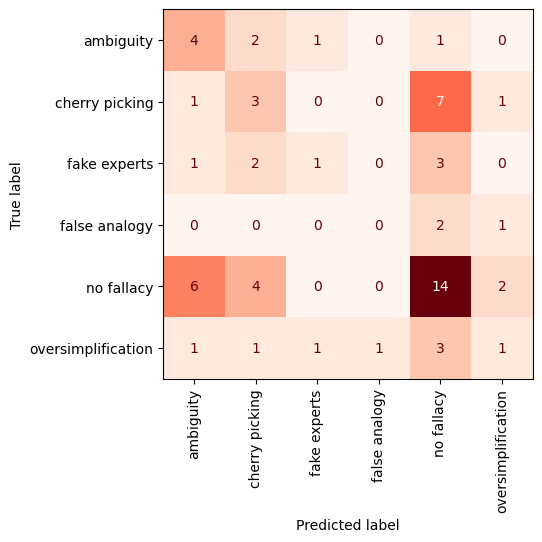

In [91]:
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
le = preprocessing.LabelEncoder()

le.fit(list(set(al_true)))

al_true = le.transform(al_true)
al_pred = le.transform(al_pred)

print(classification_report(al_true, al_pred, target_names=le.classes_, zero_division=0))
ConfusionMatrixDisplay.from_predictions(al_true, al_pred,display_labels=le.classes_, xticks_rotation='vertical', colorbar=False, cmap='Reds')

                    precision    recall  f1-score   support

        ad hominem       0.64      0.47      0.54        15
    cherry picking       0.38      0.57      0.46        40
     contradictory       0.00      0.00      0.00         4
      fake experts       0.42      0.26      0.32        19
      false choice       0.11      0.17      0.13         6
       red herring       0.22      0.21      0.22        19
slothful induction       0.27      0.21      0.24        14
         straw man       0.00      0.00      0.00         5

          accuracy                           0.35       122
         macro avg       0.25      0.24      0.24       122
      weighted avg       0.34      0.35      0.33       122



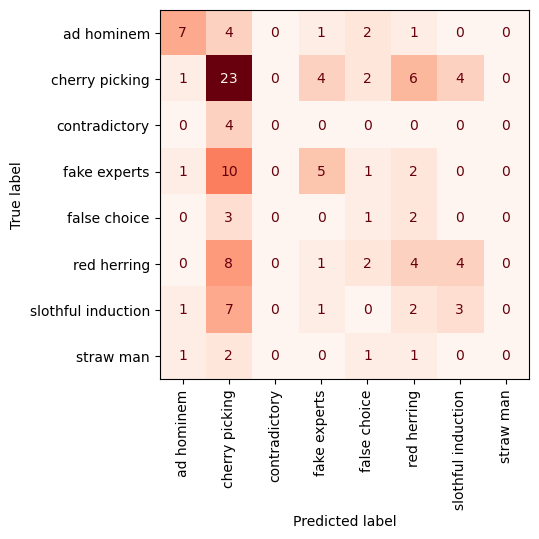

In [92]:
le = preprocessing.LabelEncoder()

le.fit(list(set(zh_true)))

zh_true = le.transform(zh_true)
zh_pred = le.transform(zh_pred)

print(classification_report(zh_true, zh_pred, target_names=le.classes_, zero_division=0))
ConfusionMatrixDisplay.from_predictions(zh_true, zh_pred,display_labels=le.classes_, xticks_rotation='vertical', colorbar=False, cmap='Reds')

In [15]:
openai.FineTune.list()

<OpenAIObject list at 0x106b1fb30> JSON: {
  "data": [
    {
      "created_at": 1685417007,
      "fine_tuned_model": "davinci:ft-personal:debunking-2023-05-30-03-28-33",
      "hyperparams": {
        "batch_size": 1,
        "learning_rate_multiplier": 0.1,
        "n_epochs": 4,
        "prompt_loss_weight": 0.01
      },
      "id": "ft-6f8iMB4KZ0Y6cUibU0EzdPK8",
      "model": "davinci",
      "object": "fine-tune",
      "organization_id": "org-PjNcLNfRcME2CPLNcOShpn6J",
      "result_files": [
        {
          "bytes": 9860,
          "created_at": 1685417314,
          "filename": "compiled_results.csv",
          "id": "file-Q5fxKUOAJ12IE9XIYoCpjEyj",
          "object": "file",
          "purpose": "fine-tune-results",
          "status": "processed",
          "status_details": null
        }
      ],
      "status": "succeeded",
      "training_files": [
        {
          "bytes": 47944,
          "created_at": 1685417006,
          "filename": "file",
          "id":